In [191]:
import gym
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
env = gym.make('MountainCar-v0')
#env = gym.wrappers.Monitor(env, 'records', force=True)
env.reset()
DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))

In [192]:
basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [233]:
numTiles = 4 * 16 * 16
numTilings = 4

# -1.2 <= position <= 0.5
# -0.07 <= velocity <= 0.07
tilingSize = 8 # (subset)
# tileSize = (max - min)/tilingSize
positionTileMovementValue = -0.2125/numTilings
velocityTileMovementValue = -0.0175/numTilings

# x = position, y = velocity
def tilecode(x,y):
    tileIndices = [-1]*numTilings
    # update position
    x = x + 1.2
    # update velocity
    y = y + 0.07

    for i in range (numTilings):
        
        positionMovementConstant = i * positionTileMovementValue
        velocityMovementConstant = i * velocityTileMovementValue

        xcoord = int(tilingSize * (x- positionMovementConstant)/1.7)
        ycoord = int(tilingSize * (y- velocityMovementConstant)/0.14)

        tileIndices[i] = i * 81 + ( ycoord * 9 + xcoord)
    return tileIndices

In [234]:
def step(x, action, v):
    v += 0.001*(action-1) + math.cos(3 * x)*(-0.0025)
    if v < -0.07:
        v = -0.07
    elif v >= 0.07:
        v = 0.06999999
    x += v
    #x = np.clip(x, -1.2, 0.5)
    reward = -1
    done = False
    if x>=0.5:
        done = True
        return x, reward, v, done
    if x <= -1.2:
        v = 0.0
    if x < -1.2:
        x = -1.2 + np.random.random()*(0.5-(-1.2))
        reward = -100
    
    return x, reward, v, done

def make_epsilon_greedy_policy(Q, nA, epsilon):

    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon/nA
        best_action = np.argmax(Q[observation])
        A[best_action] += ( 1.0 - epsilon)
        return A

    return policy_fn

In [238]:
T = 500
gamma = 1.0
discount_sigma = 0.9
Q = defaultdict(lambda : np.zeros(3))
behavior_policy = make_epsilon_greedy_policy(Q, 3,epsilon = 0.1)
target_policy = make_epsilon_greedy_policy(Q, 3,epsilon = 0.1)
n = 8
alpha = 1/7
sigma = -1
iht = IHT(2048)

def Q_sigma(num_episodes, sigma, b_pi, t_pi):
    d_sigma = False
    if sigma == -1 :
        d_sigma = True
    Q = defaultdict(lambda : np.zeros(3))
    b_pi = make_epsilon_greedy_policy(Q, 3,epsilon = 0.1)
    t_pi = make_epsilon_greedy_policy(Q, 3,epsilon = 0.1)
    count = 0
    Rewards = 0
    ARPE = []
    ARPE_no_p30= []
    for i_episode in range(num_episodes):
        rewards = 0
        if d_sigma :
#             sigma =  1.0 - (i_episode/(num_episodes-1))
            sigma = discount_sigma ** i_episode
        actions = []
        states = []
        deltas = []
        pis = []
        Qs = []
        ps = []
        
        x = -0.5
        v = 0.0
        #state = tuple(tilecode(x, v))
        state = get_discrete_state(tuple([x,v]))
        action_probs = b_pi(state)
        #action = np.random.choice(np.arange(len(action_probs)), p = action_probs)
        action = 2
        states.append(state)
        actions.append(action)
        pis.append(action_probs[action])
        Qs.append(Q[state][action])
        ps.append(t_pi(state)[action]/b_pi(state)[action])
        
        # step within each episode
        final_time = 0
        done = False
        for t in range(T) :
            x, reward, v, done = step(x, action, v)
            ### tile coding
            #next_state = tuple(tilecode(x, v))
            #print(next_state)
            ### just define 20 state
            next_state = get_discrete_state(tuple([x,v]))
            Rewards += reward
            rewards += reward
            states.append(next_state)
            if done :
                #print("done!")
                deltas.append(reward - Q[state][action])
            else :
                # Select next action
                next_action_probs = b_pi(next_state)
                next_action = np.random.choice(np.arange(len(next_action_probs)), p = next_action_probs)
                # Store
                actions.append(next_action)
                Qs.append(Q[next_state][next_action])
                pis.append(t_pi(next_state)[next_action])
                V_next = next_action_probs[0] * Q[next_state][0] + next_action_probs[1] * Q[next_state][1] + next_action_probs[2] * Q[next_state][2]
                deltas.append(reward + gamma*(sigma*Q[next_state][next_action] + (1-sigma)*V_next) - Q[state][action])
                action = next_action
                state = next_state
                ps.append(t_pi(next_state)[next_action]/b_pi(next_state)[next_action])
            # Update within each step
            tau = t - n + 1
            if tau >= 0:
                p = 1.0
                E = 1.0
                G = Q[states[tau]][actions[tau]]
                for k in range(tau,t+1):
                    G = G + E*deltas[k]
                    E = gamma*E*((1-sigma)*pis[k] + sigma)
                    p = p*(1-sigma + sigma*ps[k])
                Q[states[tau]][actions[tau]] += alpha*p*(G - Q[states[tau]][actions[tau]])
            if done :
                break
        
        for i in range(t-n+1,t+1):
            p = 1.0
            E = 1.0
            G = Q[states[i]][actions[i]]
            for k in range(i,t+1):
                G = G + E*deltas[k]
                E = gamma*E*((1-sigma)*pis[k] + sigma)
                p = p*(1-sigma + sigma*ps[k])
            Q[states[i]][actions[i]] += alpha*p*(G - Q[states[i]][actions[i]])
        
        if i_episode>=30:
            count+=1
            ARPE_no_p30.append((Rewards-pre30)/count)
        else:
            pre30 = Rewards
        
        ARPE.append(rewards)
        #print(rewards, Rewards)
    return Q, ARPE, ARPE_no_p30

In [239]:
'''
n = 4
alpha = 1/6
sigma = 1
#Q, ARPE_1, ARPE_1_no_p30 = Q_sigma(500, sigma, behavior_policy, target_policy)
n = 4
alpha = 1/4
sigma = 0.5
#Q, ARPE_05, ARPE_05_no_p30 = Q_sigma(500, sigma, behavior_policy, target_policy)
n = 8
alpha = 1/6
sigma = 0
#Q, ARPE_0, ARPE_0_no_p30 = Q_sigma(500, sigma, behavior_policy, target_policy)
'''
Q, ARPE_d, ARPE_d_no_p30 = Q_sigma(500, sigma, behavior_policy, target_policy)


470 500
0     -500.000000
1     -599.000000
2     -566.000000
3     -549.500000
4     -539.600000
          ...    
495   -200.800000
496   -200.500000
497   -200.166667
498   -199.933333
499   -192.000000
Length: 500, dtype: float64


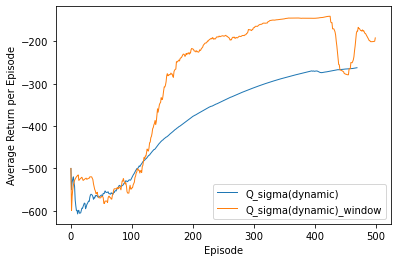

In [240]:
data_d = pd.Series(ARPE_d).rolling(window=30,min_periods=1).mean()
print(len(ARPE_d_no_p30), len(data_d))
df=pd.DataFrame({'x': range(len(ARPE_d_no_p30)),
                 #'Q_sigma(1)': ARPE_1_no_p30,
                 #'Q_sigma(0.5)': ARPE_05_no_p30,
                 #'Q_sigma(0)': ARPE_0_no_p30,
                 'Q_sigma(dynamic)': ARPE_d_no_p30,
                })
df2=pd.DataFrame({'x': range(len(data_d)),
                 'Q_sigma(dynamic)_window': data_d
                })
print(data_d)
#plt.figure(figsize=(10*len(ARPE_d_no_p30)/100,20))
#plt.plot( 'x', 'Q_sigma(1)', data=df, linewidth=1, label="Q_sigma(1)")
#plt.plot( 'x', 'Q_sigma(0.5)', data=df, linewidth=1, label="Q_sigma(0.5)")
#plt.plot( 'x', 'Q_sigma(0)', data=df,linewidth=1, label="Q_sigma(0)")
plt.plot( 'x', 'Q_sigma(dynamic)', data=df, linewidth=1, label="Q_sigma(dynamic)")
plt.plot( 'x', 'Q_sigma(dynamic)_window', data=df2, linewidth=1, label="Q_sigma(dynamic)_window")
#plt.plot( range(len(RMSE_1)), [0]*len(RMSE_1),linestyle = '--',color = 'black',linewidth=2)
#plt.plot( range(len(RMSE_1)), [0.1]*len(RMSE_1),linestyle = '--',color = 'black',linewidth=2)
#plt.plot( range(len(RMSE_1)), [0.2]*len(RMSE_1),linestyle = '--',color = 'black',linewidth=2)
#plt.plot( range(len(RMSE_1)), [0.3]*len(RMSE_1),linestyle = '--',color = 'black',linewidth=2)
plt.xlabel('Episode') 
plt.ylabel('Average Return per Episode') 
plt.legend()

In [190]:
env.close()